In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm import tnrange
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import copy
from IPython import display
import time
import sys
import japanize_matplotlib
import requests
import json
import MeCab
import re
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
import sys
sys.path.append("../input")
from API_key import apikey
from scipy import stats
import warnings
warnings.simplefilter('ignore')
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

/home/ku-miyazaki/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
with open('toxic_scores_comment_en_all.pickle', mode='rb') as f:
    tmp_dict = pickle.load(f)
    
tmp_tmp_dict = {}
for i in tmp_dict:
    tmp_tmp_dict[i] = tmp_dict[i]['attributeScores']['TOXICITY']['summaryScore']["value"]


with open('deep_senti_comment.pickle', mode='rb') as f:
    tmp_dict_id_senti = pickle.load(f)

df_id_senti = pd.DataFrame(tmp_dict_id_senti).T

with open('df_comments_all.pickle', mode='rb') as f:
    df_comments_all = pickle.load(f)

In [3]:
df_comments_all["author_id"] = df_comments_all["authorChannelUrl"].apply(lambda x: x.strip("http://www.youtube.com/channel/"))
df_comments_all["toxicity"] = df_comments_all["id"].map(tmp_tmp_dict)
df_comments_all = df_comments_all.merge(df_id_senti, left_on="id", right_index=True)
df_comments_all = df_comments_all[df_comments_all["fear"].map(type) == float]
df_comments_all["fear"] = df_comments_all["fear"].astype(float)
df_comments_all = df_comments_all[df_comments_all["toxicity"].notnull()]
df_comments_all["commentCountsByVideo"] = df_comments_all["videoId"].map(df_comments_all["videoId"].value_counts().to_dict())
df_comments_all = df_comments_all[df_comments_all["commentCountsByVideo"] >= 10]
df_comments_all["publishedAt"] = df_comments_all["publishedAt"].map(pd.Timestamp)

len(df_comments_all)

674291

In [4]:
high_fear_thre = df_comments_all["fear"].quantile(0.8)
print(high_fear_thre)
high_toxicity_thre = df_comments_all["toxicity"].quantile(0.8)
print(high_toxicity_thre)

0.032015953212976456
0.29021257


In [5]:
import scienceplots
plt.style.use(['science','nature'])
from matplotlib import rc
rc("text", usetex=False)

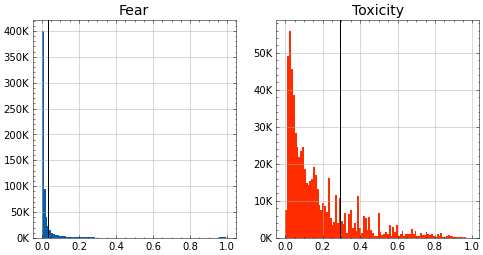

In [6]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
df_comments_all["fear"].hist(bins=100, ax=ax1, color='#0C5DA5')
ax1.axvline(x=high_fear_thre, color="black")
ax1.tick_params(axis='both', which='major', labelsize=10)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax1.get_yticks()/1000]
ax1.set_yticklabels(ylabels)
ax1.set_title("Fear", fontsize=14)
# ax1.set_xscale('log')

ax2 = fig.add_subplot(122)
df_comments_all["toxicity"].hist(bins=100, ax=ax2, color='#FF2C00')
ax2.axvline(x=high_toxicity_thre, color="black")
ax2.tick_params(axis='both', which='major', labelsize=10)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax2.get_yticks()/1000]
ax2.set_yticklabels(ylabels)
ax2.set_title("Toxicity", fontsize=14)


# plt.tight_layout()
# plt.savefig("figures/hist_coments.pdf", format="pdf", dpi=300)#, bbox_inches='tight')
plt.show()


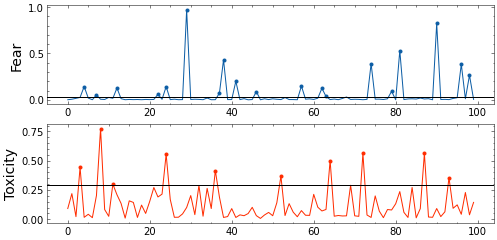

In [7]:
fig = plt.figure(figsize=(8, 4))
for c, ind_ in enumerate(df_comments_all["videoId"].value_counts().index):
    if c != 500:
        continue
    tmp_df = df_comments_all[df_comments_all["videoId"] == ind_]
    tmp_df = tmp_df.sort_values("publishedAt").reset_index()
    num = 100
    tmp_df = tmp_df.iloc[:num]
    
    ax1 = fig.add_subplot(211)
    tmp_df["fear"].plot( color='#0C5DA5')
    plt.scatter(x=tmp_df[tmp_df["fear"]>high_fear_thre].index, y=tmp_df[tmp_df["fear"]>high_fear_thre]["fear"], color='#0C5DA5')
    ax1.axhline(y=high_fear_thre, color="black")
    ax1.set_ylabel("Fear", fontsize=14)
    ax1.tick_params(axis='both', which='major', labelsize=10)

    
    ax2 = fig.add_subplot(212)
    tmp_df["toxicity"].plot(color='#FF2C00')
    plt.scatter(x=tmp_df[tmp_df["toxicity"]>high_toxicity_thre].index, y=tmp_df[tmp_df["toxicity"]>high_toxicity_thre]["toxicity"], color='#FF2C00')
    ax2.axhline(y=high_toxicity_thre, color="black")
    ax2.set_ylabel("Toxicity", fontsize=14)
    ax2.tick_params(axis='both', which='major', labelsize=10)

#     plt.savefig("figures/time_series.pdf", format="pdf", dpi=300)#, bbox_inches='tight')
    plt.show()

In [8]:
tmp_list_highfear = []
tmp_list_hightoxic = []
for c, ind_ in tqdm(enumerate(df_comments_all["videoId"].value_counts().index)):
    tmp_df = df_comments_all[df_comments_all["videoId"] == ind_]
    tmp_df = tmp_df.sort_values("publishedAt").reset_index()
    
#     tmp_df = tmp_df.iloc[:300]
    
    if len(tmp_df) < 300:
        break
    
    tmp_fear = tmp_df[tmp_df["fear"] > high_fear_thre]
    tmp_fear["publishedAt_diff"] = tmp_fear["publishedAt"].diff().apply(lambda x: x.total_seconds()/60)
    
    tmp_toxicity = tmp_df[tmp_df["toxicity"] > high_toxicity_thre]
    tmp_toxicity["publishedAt_diff"] = tmp_toxicity["publishedAt"].diff().apply(lambda x: x.total_seconds()/60)
    
    
    tmp_list_highfear.append(tmp_fear)
    tmp_list_hightoxic.append(tmp_toxicity)

0it [00:00, ?it/s]

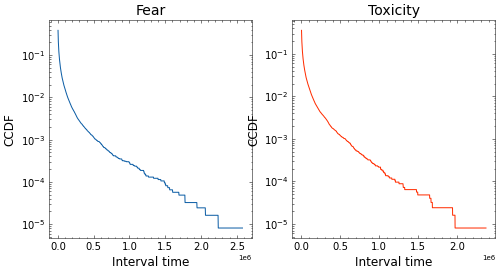

In [9]:
fig = plt.figure(figsize=(8, 4))

ax1 = fig.add_subplot(121)

tmp_sum_fear = pd.concat(tmp_list_highfear)
bins = np.linspace(0, tmp_sum_fear["publishedAt_diff"].max(), int(tmp_sum_fear["publishedAt_diff"].max()/1440))
freq = tmp_sum_fear["publishedAt_diff"].value_counts(bins=bins, sort=False)
prob = (freq / freq.sum())
prob.index = [i.right for i in prob.index]

cdf = prob.cumsum() / prob.sum()
ccdf = 1 - cdf
ccdf = ccdf.iloc[:-1]
ax1.plot([i for i in ccdf.index], ccdf, label='fear', color='#0C5DA5')
ax1.set_title("Fear", fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_xlabel("Interval time", fontsize=12)
ax1.set_ylabel("CCDF", fontsize=12)

# ax1.set_xscale('log')
ax1.set_yscale('log')
# 

ax2 = fig.add_subplot(122)

tmp_sum_toxic = pd.concat(tmp_list_hightoxic)
bins = np.linspace(0, tmp_sum_toxic["publishedAt_diff"].max(), int(tmp_sum_toxic["publishedAt_diff"].max()/1440))
freq = tmp_sum_toxic["publishedAt_diff"].value_counts(bins=bins, sort=False)
prob = (freq / freq.sum())
prob.index = [i.right for i in prob.index]

cdf = prob.cumsum() / prob.sum()
ccdf = 1 - cdf
ccdf = ccdf.iloc[:-1]
ax2.plot([i for i in ccdf.index], ccdf, label='toxicity', color='#FF2C00')
ax2.set_title("Toxicity", fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=10)

ax2.set_xlabel("Interval time", fontsize=12)
ax2.set_ylabel("CCDF", fontsize=12)

# ax2.set_xscale('log')
ax2.set_yscale('log')

# plt.tight_layout()
# plt.savefig("figures/interval_log.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()

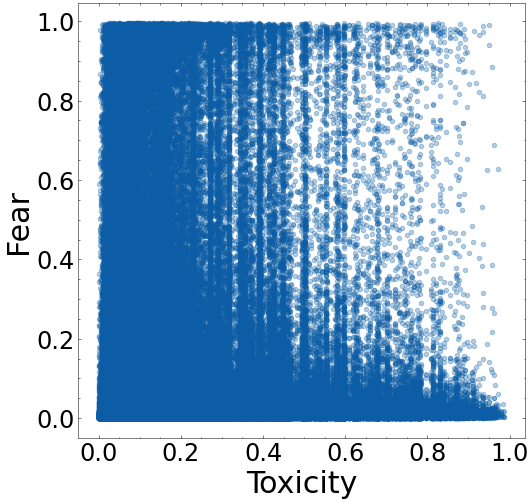

In [10]:
# df_comments_all[df_comments_all["fear"].map(type) == float].plot.scatter(x="toxicity", y="fear", alpha=0.3)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
df_comments_all[df_comments_all["fear"].map(type) == float].plot.scatter(x="toxicity", y="fear", alpha=0.3, ax=ax)
# X = df_comments_all["toxicity"].values.reshape(-1, 1)
# Y = df_comments_all["fear"].values.reshape(-1, 1)
# linear_regressor = LinearRegression()
# linear_regressor.fit(X, Y)
# print(linear_regressor.coef_)
# print(np.corrcoef(X.reshape(1, -1), Y.reshape(1, -1))[0][1])
# Y_pred = linear_regressor.predict(X)

ax.set_ylabel("Fear", fontsize=30)
ax.set_xlabel("Toxicity", fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=24)

# plt.plot(X, Y_pred, color='#FF2C00', linewidth=5)
# plt.savefig("figures/scatter_commentlevel_noline.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

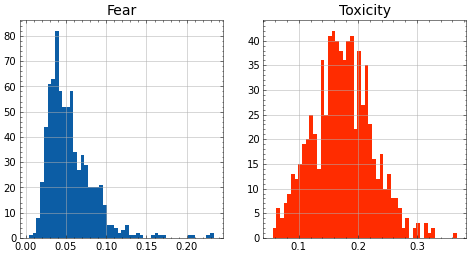

In [11]:

fig = plt.figure(figsize=(8, 4))
ax3 = fig.add_subplot(121)
tmp_comments = df_comments_all[df_comments_all["commentCountsByVideo"] > 100]
(
    tmp_comments.groupby("videoId")["fear"].mean()
).hist(bins=50, ax=ax3, color='#0C5DA5')
ax3.tick_params(axis='both', which='major', labelsize=10)
# ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax3.get_yticks()/1000]
# ax3.set_yticklabels(ylabels)
ax3.set_title("Fear", fontsize=14)

ax4 = fig.add_subplot(122)
(
    tmp_comments.groupby("videoId")["toxicity"].mean()
).hist(bins=50, ax=ax4, color='#FF2C00')
ax4.tick_params(axis='both', which='major', labelsize=10)
# ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax4.get_yticks()/1000]
# ax4.set_yticklabels(ylabels)
ax4.set_title("Toxicity", fontsize=14)

# plt.savefig("figures/hist_videos2.pdf", format="pdf", dpi=300)#, bbox_inches='tight')
plt.show()


[[0.0648832]]
0.10404740431006793


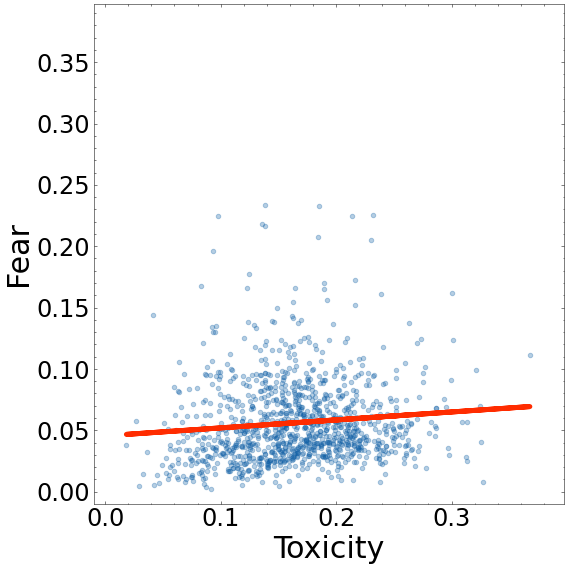

In [12]:
fig = plt.figure(figsize=(8, 8))
ax2 = fig.add_subplot(111)
tmp_plot = df_comments_all[df_comments_all["fear"].map(type) == float].groupby("videoId")["toxicity", "fear"].mean()
tmp_plot.plot.scatter(x="toxicity", y="fear", alpha=0.3, ax=ax2)
X = tmp_plot["toxicity"].values.reshape(-1, 1)
Y = tmp_plot["fear"].values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
print(linear_regressor.coef_)
print(np.corrcoef(X.reshape(1, -1), Y.reshape(1, -1))[0][1])
Y_pred = linear_regressor.predict(X)

ax2.set_ylabel("Fear", fontsize=30)
ax2.set_xlabel("Toxicity", fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=24)
ax2.set_xlim(-0.01, max(X.max(), Y.max())+0.03)
ax2.set_ylim(-0.01, max(X.max(), Y.max())+0.03)

plt.plot(X, Y_pred, color='#FF2C00', linewidth=5)

plt.tight_layout()
# plt.savefig("figures/scatter_videolevel.png", format="png", dpi=300, bbox_inches='tight')
plt.show()